In [36]:
import os
import clip
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json

In [37]:
config = {
    "device":"cuda" if torch.cuda.is_available() else "cpu",
    "datapath":"/data/dlcv/hw3/hw3_data/p1_data/val/",
    "datajson":"/data/dlcv/hw3/hw3_data/p1_data/id2label.json",
    "bsz":250
}
if config["device"] == "cuda":
    torch.cuda.set_device(1)
print('Device used :', config["device"])

Device used : cuda


In [38]:
class DS(Dataset):
    def __init__(self, dirpath, transform=None) -> None:
        self.data = []
        self.transform = transform
        if os.path.exists(dirpath):
            filenames = glob.glob(os.path.join(dirpath, "*.png"))
            for filename in filenames:
                label = int((os.path.split(filename))[-1].split("_")[0])
                self.data.append((filename, label))
        else:
            print("Can't open {}".format(dirpath))
            exit(-1)
        self.len = len(self.data)
    def __getitem__(self, index):
        imgpath, label = self.data[index]
        img = Image.open(imgpath)
        if self.transform:
            img = self.transform(img)
        return img, label, imgpath
    def __len__(self):
        return self.len

In [39]:
with open(config["datajson"]) as f:
    id2label = json.load(f)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {val}?") for key, val in id2label.items()]).to(config["device"])
model, preprocess = clip.load('ViT-B/32', config["device"])
test_dataset = DS(dirpath=config["datapath"], transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=config["bsz"], pin_memory=True)

In [40]:
with torch.no_grad():
    acc = 0
    for i, (img, label, __) in enumerate(test_loader):
        img, label = img.to(config["device"]), label.to(config["device"])
        logits_per_images, logit_per_text = model(img, text_inputs)
        pred = logits_per_images.softmax(dim=-1).argmax(dim=-1)
        acc += (pred == label).float().sum()
    print("Accuracy : {:.2%}".format(acc / len(test_loader.dataset)))

Accuracy : 72.24%


In [41]:
prompts = ["This is a photo of {}", "This is a {} image.", "No {}, no score."]
for prompt in prompts:
    text_inputs = torch.cat([clip.tokenize(prompt.format(val)) for key, val in id2label.items()]).to(config["device"])
    with torch.no_grad():
        acc = 0
        for i, (img, label, __) in enumerate(test_loader):
            img, label = img.to(config["device"]), label.to(config["device"])
            logits_per_images, logit_per_text = model(img, text_inputs)
            pred = logits_per_images.softmax(dim=-1).argmax(dim=-1)
            acc += (pred == label).float().sum()
        print("{} Accuracy : {:.2%}".format(prompt.format("{}"), acc / len(test_loader.dataset)))

This is a photo of {} Accuracy : 60.84%
This is a {} image. Accuracy : 68.16%
No {}, no score. Accuracy : 56.36%


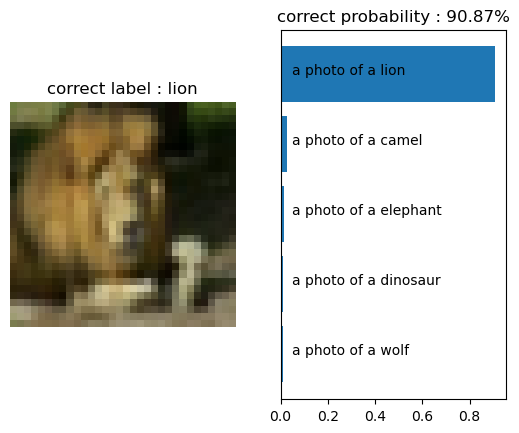

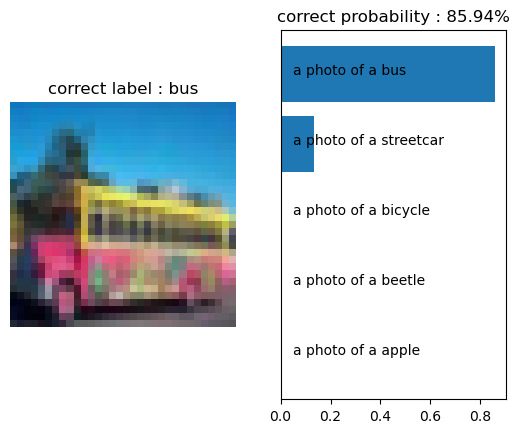

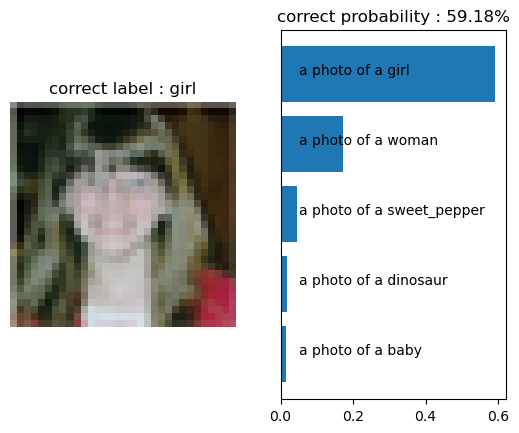

In [57]:
randidx = [0, 3, 21]
text_inputs = torch.cat([clip.tokenize(f"a photo of a {val}.") for key, val in id2label.items()]).to(config["device"])
test_dataset = next(iter(test_loader))
imgset, labelset, pathset = test_dataset[0], test_dataset[1], test_dataset[2]
with torch.no_grad():
    for idx in randidx:
        img, label, imgpath = imgset[idx], labelset[idx], pathset[idx]
        img, label = img.unsqueeze(0).to(config["device"]), label.unsqueeze(0).to(config["device"])
        image_features = model.encode_image(img)
        text_features = model.encode_text(text_inputs)
        # Pick the top 5 most similar labels for the image
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        values, indices = similarity[0].topk(5)
        # print(values, indices)
        plt.figure(idx)
        plt.subplot(121)
        plt.title("correct label : {}".format(id2label[str(label.item())])), plt.axis('off')
        plt.imshow(np.array(Image.open(imgpath)))
        plt.subplot(122)
        plt.title("correct probability : {:.2%}".format(values[0]))
        plt.barh(np.arange(5, 0, -1), values.cpu().numpy())
        plt.gca().get_yaxis().set_visible(False)
        for i in range(5, 0, -1):
            plt.text(0.05, i, "a photo of a {}".format(id2label[str(indices[5-i].item())]))
        plt.show()
        